# Производительность парогенератора

Этот простой пример построения модели, описывающей изменение количества вырабатываемого парогенератором пара в зависимости от подаваемого на вход топлива, приведён в книге [[1]](#VoschininSotirov1989). Он иллюстрирует основные шаги построения и анализа интервальных регрессионных моделей при точно задаваемых входных переменных и наличии интервальной неопредлённости в выходной переменной.

## Набор данных

Рассмотрим процедуру построения и анализа зависимости по интервальным данным на примере исследования парогенератора типа БК-3-210, широко используемого на ТЭЦ для выработки пара высокого давления.

Основной эксплуатационной  характеристикой агрегата является зависимость его производительности $y$, измеряемой как расход пара на выходе агрегата, от расхода топлива $x$ на входе агрегата.

В результате испытаний парогенератора после проведения регламентных работ были получены данные трёх измерений, причём расход пара измерялся с 5%-й относительной ошибкой. Полученные данные сведены в таблицу.

|  *i* | $x$ | $y$ | $\varepsilon$ | $y^{-} = y - \varepsilon$ |  $y^{+} = y + \varepsilon$ |
| :---: |:------- | :--------: | :--------: |  :--------: | :--------: |
| 1 | $12$ | $128$ | $6$  | $122$ | $134$ |
| 2 | $16$ | $180$ | $9$  | $171$ | $189$ |
| 3 | $20$ | $230$ | $11$ | $119$ | $241$ |

Здесь  
 *i* &mdash; номер опыта;  
 $y_i$ &mdash; значение производительности агрегата, измеренное в $i$-м опыте;  
 $\varepsilon = 0.05y$; &mdash; предельный уровень ошибки измерения  $y_i$ (величина неопредлённости, радиус интервала  $\mathbf{y}_i$);  
 $y_{i}^{-} = y_i - \varepsilon_i$ &mdash; нижняя граница интервального измерения $\mathbf{y}_i$;   
 $y_{i}^{+} = y_i + \varepsilon_i$  &mdash; верхняя граница интервального измерения $\mathbf{y}_i$.
 
Для перехода к практическим вычислениям необходимо указать путь к функциям построения и анализа интервальной регрессии, а также загрузить исходный набор данных.

In [1]:
## Установить пути к функциям построения интервальной регрессии
addpath(genpath('./m'))

## Загрузить исходные данные
load data/steam.mat
steam

steam =

  scalar structure containing the fields:

    title = Зависимость производительности парогенератора (выхода пара) от расхода топлива
    refs = Вощинин А.П., Сотиров Г.Р. Оптимизация в условиях неопределенности. М.: Изд-во МЭИ; София: Техника, 1989. -- 224 с.
    vars =
    {
      [1,1] = fuel_consumption
      [2,1] = steam_output
      [3,1] = steam_output_eps
    }

    data =

        12   128     6
        16   180     9
        20   230    11




## Структура модели и информационное множество

Известно, что у парогенераторов типа БК-3-210 зависимость $y = f(x)$ является достаточно гладкой неубывающей функцией.

В связи с этим было решено искать модель агрегата в классе линейных функций 

$$y = \beta_1 + \beta_2 x$$ 

с неотрицательной первой производной. 

Эти условия в совокупности с данными интервальных измерений приводят к следующей системе неравенств для неизвестных параметров $\beta_1$ и $\beta_2$:

$$122 \leq \beta_1 + 12 \beta_2 \leq 134,$$
$$171 \leq \beta_1 + 16 \beta_2 \leq 189,$$
$$230 \leq \beta_1 + 20 \beta_2 \leq 241,$$
$$0 \leq \beta_2,$$

Множество решений этой системы неравенств, т. е. оценок параметров искомой зависимости, является главным объектом последующего анализа и именуется **информационным множеством задачи**.

На основе набора данных, гипотез о структуре модели и дополнительных ограничений, вытекающих из априорных сведений о моделируемом явлении, формируется переменная, содержащая описание задачи построения интервальной регрессии.

In [2]:
## Определить задачу построения интервальной регрессии 
##     y = X * beta = beta1 + beta2 * x 
## с ограничением beta2 >= 0

x = steam.data(:,1);        # количество затраченного топлива
y = steam.data(:,2);        # объем произведенного пара
epsilon = steam.data(:,3);  # верхняя граница ошибки для y_i

X = [ x.^0 x ];                               # матрица значений переменных при beta1 и beta2
lb = [-inf 0];                                # нижние границы beta1 и beta2
irp_steam = ir_problem(X, y, epsilon, lb);    # создание переменной, содержащей описание задачи 
                                              #               построения интервальной регрессии

Первичное представление о данных позволяет получить их графическое представление.

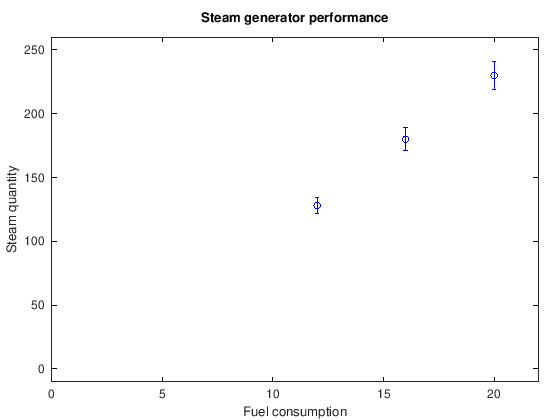

In [3]:
## График интервальных измерений
figure
ir_scatter(irp_steam);   
xlim([0 22])
ylim([-10 260])
set(gca, 'fontsize', 12)
title('Steam generator performance');
xlabel('Fuel consumption');
ylabel('Steam quantity');

Поскольку информационное множество задачи построения линейной зависимости по интервальным данным задаётся системой линейных неравенств, то оно представляет собой выпуклый многогранник. 

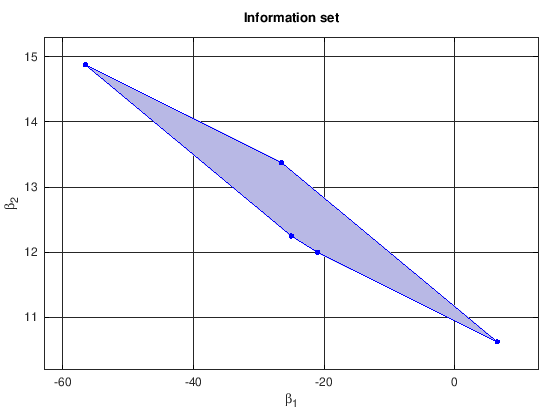

In [4]:
## Графическое представление информационного множества
ir_plotbeta(irp_steam)
grid on
set(gca, 'fontsize', 12)
xlabel('\beta_1')
ylabel('\beta_2')
title('Information set')

Полезным представлением многогранника информационного множества $B$ служит набор его вершин $b_i$. В частности,  расстояние между наиболее удалёнными вершинами (диаметр этого многогранника $\rho(B)$), может служить мерой  неопределённости задачи.

In [5]:
## Вершины информационного множества задачи построения интервальной регрессии
vertices = ir_beta2poly(irp_steam)

## Диаметр и наиболее удаленные вершины информационного множества 
[rhoB, b1, b2] = ir_betadiam(irp_steam)

vertices =

  -26.5000   13.3750
  -56.5000   14.8750
  -25.0000   12.2500
  -21.0000   12.0000
    6.5000   10.6250

rhoB =  63.143
b1 =

    6.5000   10.6250

b2 =

  -56.500   14.875



В рассматриваемом простом примере информационное множество задачи оказалось непустым. В общем же случае информационное множество задачи может оказаться пустым, что свидетельствует о наличии противоречий (несовместности) в данных и ограничениях задачи. Для разрешения противоречий можно прибегать к некоторым специальным приёмам (см. блокнот *Построение зависимостей для несовместных данных*).

## Интервальные и точечные оценки параметров

Один из главных вопросов при построении регрессии -- оценивание её параметров. В зависимости от прикладных целей  характер и назначение искомых оценок могут существенно разниться.

Внешняя интервальная оценка параметра определяется минимальным и максимальным значениями, которых может достигать значение параметра в информационном множестве.

В совокупности интервальные оценки параметров задают брус, описанный вокруг информационного множества и именуемый **внешней интервальной оболочкой информационного множества**.


In [6]:
## Внешние интервальние оценки параметров модели y = beta1 + beta2 * x 
b_int = ir_outer(irp_steam)


b_int =

  -56.5000    6.5000
   10.6250   14.8750



Роль точечной оценки параметров зависимости может исполнять любая из точек информационного множества. В некоторых случаях прикладные соображения могут диктовать опредёленные предпочтения, приводящие к выбору некоторой "центральной" точки информационного множества.

Возможными кандидатами на роль такого центра могут служить:

* центр наибольшей диагонали информационного множества
$$\hat{\beta}_{\text{maxdiag}} = 0.5(b_1 + b_2),$$

* центр тяжести информационного множества
$$\hat{\beta}_{\text{gravity}} = \frac{1}{5} \sum_{i=1}^5 b_i.$$

Отметим, что в рассматриваемом случае все эти оценки практически совпадают и, кроме того, к ним также близка и оценка метода наименьших квадратов $\hat{\beta}_{\text{LSM}}$ (которая в общем случае может и не принадлежать информационному множеству).

Существуют и другие варианты построения центроидов информационного множества.


In [7]:
## Точечные оценки параметров 
b_maxdiag = (b1 + b2) / 2    # как середина наибольшей диагонали информационного множества

b_gravity = mean(vertices)   # как центр тяжести информационного множества 

b_lsm = (X \ y)'             # методом наименьших квадратов


b_maxdiag =

  -25.000   12.750

b_gravity =

  -24.500   12.625

b_lsm =

  -24.667   12.750



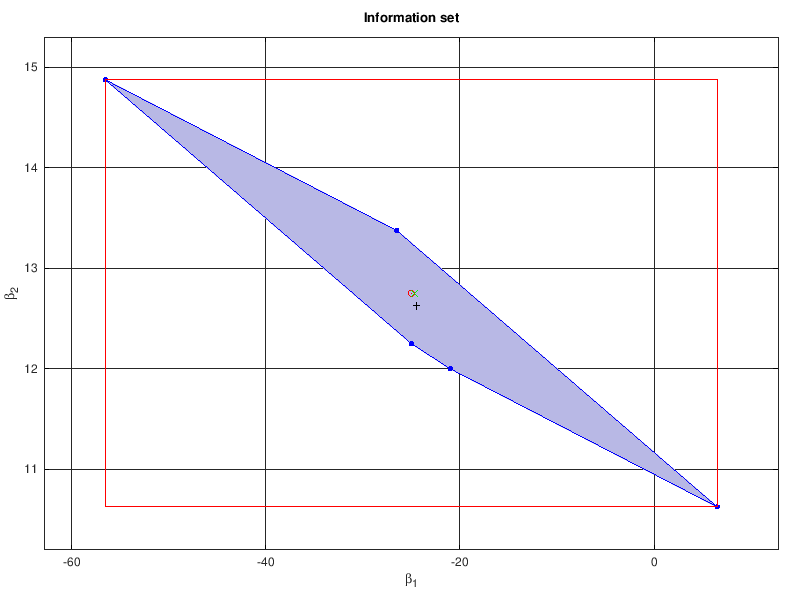

In [8]:
## Графическое представление внешней интервальной оценки информационного множества
figure(1, 'position',[0, 0, 800, 600]);
ir_plotbeta(irp_steam)
hold on
ir_plotrect(b_int,'r-')
grid on
set(gca, 'fontsize', 12)
xlabel('\beta_1')
ylabel('\beta_2')
title('Information set')

## Точечные оценки
plot(b_maxdiag(1), b_maxdiag(2), 'ro')
plot(b_gravity(1), b_gravity(2), 'k+')
plot(b_lsm(1), b_lsm(2), 'gx')

## Коридор совместных зависимостей

Информационное множество задачи определяется в пространстве параметров. Каждая его точка $(\beta_1,\beta_2)$  задаёт зависимость в пространстве переменных $(x, y)$. Множество всех таких моделей именуется **коридором совместных зависимостей**. 

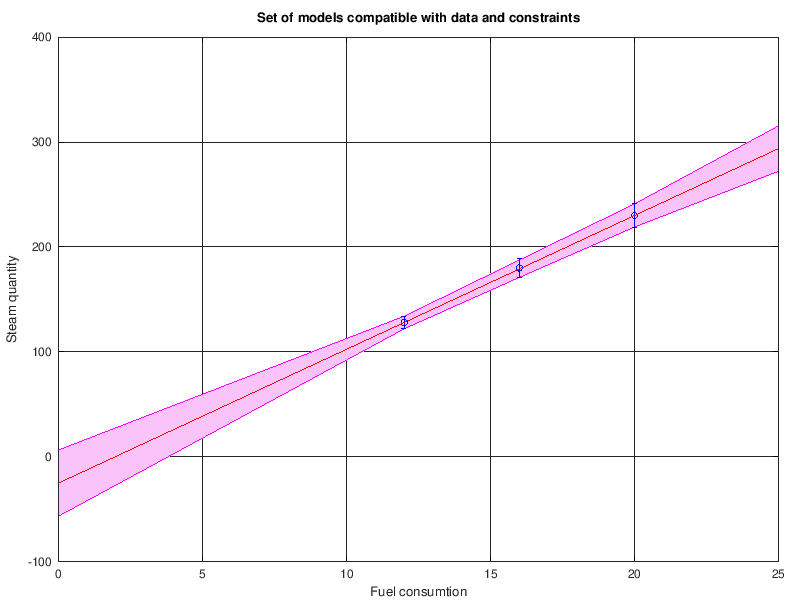

In [9]:
## Графическое представление коридора совместных зависимостей для модели y = beta1 + beta2 * x
figure(1, 'position',[0, 0, 800, 600]);
xlimits = [0 25];
ir_plotmodelset(irp_steam, xlimits)     # коридор совместных зависимостей
hold on
ir_scatter(irp_steam,'bo')              # интервальные измерения
ir_plotline(b_maxdiag, xlimits, 'r-')   # зависимость с параметрами, оцененными как центр наибольшей диагонали ИМ
#ir_plotline(b_gravity, xlim, 'b--')     # зависимость с параметрами, оцененными как центр тяжести ИМ  
#ir_plotline(b_lsm, xlim, 'b--')         # зависимость с параметрами, оцененными МНК
#ir_scatter(ir_problem(Xp,ypmid,yprad),'ro')

grid on
set(gca, 'fontsize', 12)
xlabel('Fuel consumtion')
ylabel('Steam quantity')
title('Set of models compatible with data and constraints')

## Прогноз значений выходной переменной

Пожалуй, главным предназначением регрессионной модели является предсказание значений выходной переменной для заданных значений входной.

С помощью построенной выше модели $$\mathbf{y}(x) = [-56.5, 6.5] + [10.625, 14.875] x$$ можно получить прогнозные значения выходной переменной в точках эксперимента:

In [10]:
## Значения y, предсказанные с помощью модели y = beta1 + beta2 * x в точках эксперимента
yp0 = ir_predict(X, irp_steam)       # интервальный прогноз значений y в точках x

yp0mid = mean(yp0,2)                 # средние значения прогнозных интервалов
yp0rad = 0.5 * (yp0(:,2) - yp0(:,1)) # радиус прогнозных интервалов

yp0rad_rel = 100 * yp0rad ./ yp0mid  # относительная величина неопределенности прогнозов в процентах

yp0 =

   122.00   134.00
   171.00   187.50
   219.00   241.00

yp0mid =

   128.00
   179.25
   230.00

yp0rad =

    6.0000
    8.2500
   11.0000

yp0rad_rel =

   4.6875
   4.6025
   4.7826



Соотношение прогнозных и исходных интервалов в исходных точках измерений является одним из показателей качества построенной модели. 

Однако ценность модели заключается в возможности её употребления для предсказания выходной переменной в точках, где измерения не производились. 

In [11]:
## Значения y, предсказанные с помощью модели y = beta1 + beta2 * x
xp = [10; 15; 17.5; 22.5]
Xp = [xp.^0 xp];

yp = ir_predict(Xp, irp_steam)         # интервальный прогноз значений y в точках xp
ypmid = mean(yp,2)                     # средние значения прогнозных интервалов
yprad = 0.5 * (yp(:,2) - yp(:,1))      # радиус прогнозных интервалов

yprad_relative = 100 * yprad ./ ypmid  # относительная величина неопределенности прогнозов в процентах

xp =

   10.000
   15.000
   17.500
   22.500

yp =

    92.250   112.750
   158.750   174.125
   189.000   207.562
   245.563   278.187

ypmid =

   102.50
   166.44
   198.28
   261.88

yprad =

   10.2500
    7.6875
    9.2812
   16.3125

yprad_relative =

   10.0000
    4.6189
    4.6809
    6.2291



Следует обратить внимание, что величина неопределённости прогнозов растёт по мере удаления от области, в которой производились исходные измерения. Это обусловлено видом коридора зависимостей, расширяющимся за пределами области измерений, и согласуется со здравым смыслом.

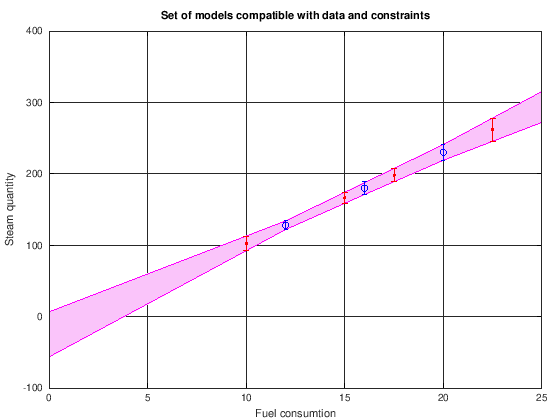

In [12]:
## Коридор совместных зависимостей для модели y = beta2 * x
ir_plotmodelset(irp_steam,xlimits)
grid on
hold on
ir_scatter(irp_steam,'bo')
ir_scatter(ir_problem(Xp,ypmid,yprad),'r.')
xlabel('Fuel consumtion')
ylabel('Steam quantity')
title('Set of models compatible with data and constraints')

## Уточнение структуры модели

Анализируя полученные интервальные оценки параметров и геометрическое представление множества $B$, можно прийти к выводу, что в угловых точках $b_1$ и $b_2$ оценка параметра $\beta_1$ имеет разные знаки и, следовательно, правомерно принятие гипотезы $H_0: \beta_1 = 0$.

Используя более простую структуру модели $y = \beta_2 x$ (без коэффициента $\beta_1$) и данные эксперимента, получаем следующую систему неравенств: 

$$122 \leq 12 \beta_2 \leq 134,$$
$$171 \leq 16 \beta_2 \leq 189,$$
$$230 \leq 20 \beta_2 \leq 241,$$
$$0 \leq \beta_2,$$

Решение новой задачи построения интервальной регрессии дает существенно более узкие интервальные оценки параметра $\beta_2$. 

In [13]:
## Определить задачу интервальной регрессии y = beta2 * x с ограничением beta2 >= 0
lb = [0];
irp_steam2 = ir_problem(x, y, epsilon, lb);    # описание задачи интервальной регрессии

## Внешняя интервальная оценка параметра модели y = beta2 * x 
b_int2 = ir_outer(irp_steam2)          # интервальная оценка 
b_rad2 = 0.5 * (b_int2(2) - b_int2(1)) # ширина интервальной оценки
b_mid2 = mean(b_int2)                  # центр интервала как точечная оценка параметра beta2

## Оценка параметра beta2 методом наименьших квадратов
b_lsm2 = x \ y  

b_rad2_rel = 100 * b_rad2 / b_mid2     # относительная точность оценки параметра в процентах

b_int2 =

   10.950   11.167

b_rad2 =  0.10833
b_mid2 =  11.058
b_lsm2 =  11.270
b_rad2_rel =  0.97965


Как видно, интервальная оценка параметра $\mathbf{\beta}_2 = [10.95, 11.17]$ надёжно идентифицирует знак параметра $\beta_2$  и соответствует требуемому условию $\beta_2 \geq 0$. При этом ширина интервальной оценки относительно невелика: $\overline{\beta_2} - \underline{\beta_2} = 0.2$.

В качестве точечной оценки коэффициента $\beta_2$ целесообразно взять оценку $\text{mid}\;{\mathbf{\beta}_2} = 11.058,$ соответствующую середине интервала.

Относительная ошибка оценивания параметра $\beta_2$ с использованием этой точечной оценки составляет ~1%, что в пять раз меньше относительной ошибки измерения выходной величины.

Заметим, что МНК-оценка параметра $\beta_2,$ вычисленная по средним значениям $y_i$ и равная 11.27, не попадает в интервал $[10.95, 11.17]$ возможных значений $\beta_2$ и не укладывается в сделанные допущения.

С помощью построенной уточнённой модели можно получить прогнозные значения выходной переменной в точках эксперимента:

In [14]:
## Значения y, предсказанные с помощью модели y = beta2 * x
xp = [12; 16; 20] 
yp2 = ir_predict(xp, irp_steam2)      # интервальный прогноз значений y в точках xp
yp2mid = mean(yp2,2)                  # средние значения прогнозных интервалов
yp2rad = 0.5 * (yp2(:,2) - yp2(:,1))  # радиус прогнозных интервалов

yp2rad_rel = yp2rad ./ yp2mid         # относительная величина неопределенности прогнозов в процентах

xp =

   12
   16
   20

yp2 =

   131.40   134.00
   175.20   178.67
   219.00   223.33

yp2mid =

   132.70
   176.93
   221.17

yp2rad =

   1.3000
   1.7333
   2.1667

yp2rad_rel =

   0.0097965
   0.0097965
   0.0097965



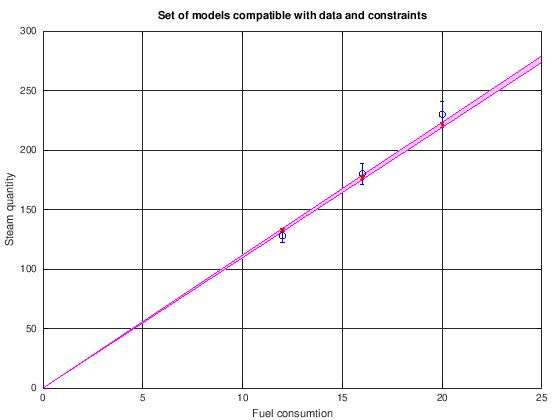

In [15]:
## Коридор совместных зависимостей для модели y = beta2 * x
ir_plotmodelset(irp_steam2,xlimits)
grid on
hold on
ir_scatter(irp_steam2,'bo')
ir_scatter(ir_problem(xp,yp2mid,yp2rad),'r.')
xlabel('Fuel consumtion')
ylabel('Steam quantity')
title('Set of models compatible with data and constraints')

Таким образом, по результатам трех интервальных измерений получена достаточно точная и удовлетворяющая физическим ограничениям модель агрегата в виде

$$\mathbf{y}(x) = [10.95, 11.17] x.$$

<a id='refs'></a>
## Список литературы

1. 1. <a id='VoschininSotirov1989'></a> Вощинин А.П., Сотиров Г.Р. Оптимизация в условиях неопределенности. М.: Изд-во МЭИ; София: Техника, 1989. -- 224 с. 

